<table class="ee-notebook-buttons" align="center">
    <td><a target="_blank"  href="https://colab.research.google.com/github/yotarazona/scikit-eo/blob/main/examples/notebooks/11_Deep_Learning_Classification_FullyConnected.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

# **_<div class="alert alert-success"><font color='darkred'> Tutorials: 11 Deep Learning Classification</font></div>_**

# 1.0 Libraries

To install ```scikit-eo``` you can do it with the following line:

In [ ]:
!pip install scikeo

Libraries to be used:

In [1]:
import rasterio
import numpy as np
from scikeo.deeplearning import DL
from scikeo.plot import plotRGB
from scikeo.process import extract
import matplotlib.pyplot as plt
from dbfread import DBF
import matplotlib as mpl
import pandas as pd
import geopandas as gpd

Reading dataset directly from the external server (GitHub in this case). To do this, ```requests```, ```zipfile``` and ```io``` will be installed before. Then you will only need to run the following line:

In [2]:
import requests, zipfile
from io import BytesIO

# Defining the zip file URL
url = 'https://github.com/yotarazona/data/raw/main/data/11_deepLearning.zip'

# Split URL to get the file name
filename = url.split('/')[-1]

# Downloading the file by sending the request to the URL
req = requests.get(url)

# extracting the zip file contents
file = zipfile.ZipFile(BytesIO(req.content))
file.extractall()

## 2.0 Optical image

Landsat-8 OLI (Operational Land Imager) will be used to obtain in order to classify using Deep Learning. This image, which is in surface reflectance with bands:
- Blue -> B2
- Green -> B3
- Red -> B4
- Nir -> B5
- Swir1 -> B6
- Swir2 -> B7

Classes to be mapped are:
- forest
- agriculture
- urban area and
- water

In [3]:
data_dir = "11_deepLearning/"

path_raster = data_dir + "LC08_232066_20190727_SR.tif"
img = rasterio.open(path_raster)

path_endm = data_dir + "endmembers.shp"
endm = gpd.read_file(path_endm)

In [4]:
# endmembers
endm = extract(img, endm)
endm

,class,band1,band2,band3,band4,band5,band6
0,1.0,646,1137,1446,569,53,33
1,1.0,658,1141,1449,585,68,44
2,1.0,663,1149,1455,573,67,43
3,1.0,657,1147,1453,556,48,29
4,1.0,662,1147,1451,557,52,31
...,...,...,...,...,...,...,...
314,4.0,566,802,1046,2649,3759,2296
315,4.0,403,542,696,2013,2932,1676
316,4.0,622,897,1173,2613,3943,2635
317,4.0,533,772,990,2604,3177,1967


Classes must start at 0 to run this model.

In [9]:
endm['class'] = endm['class'] - 1
endm

,class,band1,band2,band3,band4,band5,band6
0,0.0,646,1137,1446,569,53,33
1,0.0,658,1141,1449,585,68,44
2,0.0,663,1149,1455,573,67,43
3,0.0,657,1147,1453,556,48,29
4,0.0,662,1147,1451,557,52,31
...,...,...,...,...,...,...,...
314,3.0,566,802,1046,2649,3759,2296
315,3.0,403,542,696,2013,2932,1676
316,3.0,622,897,1173,2613,3943,2635
317,3.0,533,772,990,2604,3177,1967


## 3.0 Model architecture

This version of **scikit-eo**, provides a Deep Learning algorithm called *Fully connected layers*. This model is an algorithm that consists of a network with a sequence of Dense layers (Multi-Layer Perceptron), which area densely connnected (also called *fully connected*) neural layers, this is the simplest of deep learning models. In this architecture, the number of units or neurons characterizes the dense layers. In other words, the model is a matrix multiplication operation as shown in the following equation:

$$g\left(Wx+b\right)$$

where, $g$ represents an activation function, $W$ are weights, $x$ represents samples, and $b$ represents bias.

Activation functions *relu* and *softmax* were used for the neurons in each hidden layer and for the final classification, respectively. *Softmax* is used for more than two land covers. 

The function initializes the weights $𝑊$, then adjust the weights in such a way that the output of neural network is consistent with classes labels during the training. To minimize the error function, *Gradient Descent* and the *backpropagation algorithm* are used.


Instance of ```DL()```:

In [14]:
inst = DL(image = img, endmembers = endm)

Applying the ```FullyConnected()``` function of Deep Learning:

- *Number of hidden layers to be used*: 4
- *Number of units to be used*. This is related to 'neurons' in each hidden layers [64,16,8,8]
- *Number of clases to be obtained*: output_units is 4 (four classes)
- *Input_shape*: The input shape is generally the shape of the input data provided to the Keras model while training
- *Epochs*: Number of iterations iqual 100
- *Batch_size*: 32
- *Training_split*: 70%

In [15]:
fc = inst.FullyConnected(hidden_layers = 4,
                         hidden_units = [64,16,8,8],
                         output_units = 4,
                         input_shape = (6,),
                         epochs = 100,
                         batch_size = 32,
                         training_split = 0.7)

C:\Users\USER\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50744/50744 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


## 3.0 Results

Dictionary of results

In [16]:
fc.keys()

dict_keys(['Overall_Accuracy', 'Kappa_Index', 'Confusion_Matrix', 'Classification_Map', 'Image'])

Overall Accuracy

In [17]:
fc.get('Overall_Accuracy')

0.9166666666666666

Kappa index

In [18]:
fc.get('Kappa_Index')

0.8787878787878788

Confusion matrix or error matrix

In [19]:
fc.get('Confusion_Matrix')

,0,1,2,3,Total,Users_Accuracy,Commission
0,18.0,0.000000,0.0,0.000000,18.0,100.000000,0.000000
1,0.0,11.000000,0.0,1.000000,12.0,91.666667,8.333333
2,0.0,0.000000,18.0,0.000000,18.0,100.000000,0.000000
3,0.0,7.000000,0.0,41.000000,48.0,85.416667,14.583333
Total,18.0,18.000000,18.0,42.000000,NaN,NaN,NaN
Producer_Accuracy,100.0,61.111111,100.0,97.619048,NaN,NaN,NaN
Omission,0.0,38.888889,0.0,2.380952,NaN,NaN,NaN


Preparing the image before plotting

In [20]:
# Let's define the color palette
palette = mpl.colors.ListedColormap(['dodgerblue','#e84855','darkgreen','#ADC178'])

Applying the ```plotRGB``` algorithm is easy:

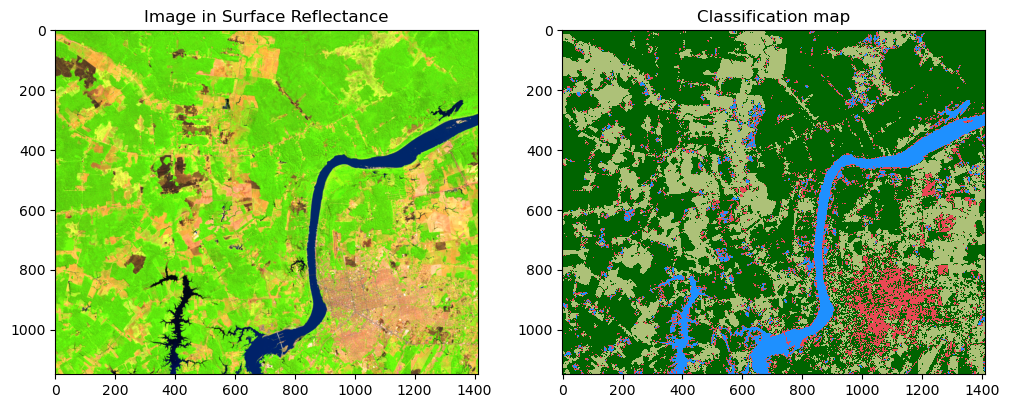

In [22]:
# Let´s plot
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 7))

# satellite image
plotRGB(img, bands = [5, 4, 3], title = 'Image in Surface Reflectance', ax = axes[0])

# class results
axes[1].imshow(fc.get('Classification_Map'), cmap = palette)
axes[1].set_title("Classification map")
axes[1].grid(False)

**Important!**

As you can see, using *Fully connected layer* is not as complicated as it may seem. In fact, it is possible to improve the accuracy of the model or the final classification result. How can we improve the accuracy?
There are some hyper-parameters that you can modify in order to increase the accuracy of the model.

- *Hidden layers*: You can increase the number of hidden layers in order to improve the prediction model.
- *Number of neurons*: You can increase the number of neurons in each hidden layer in order to further improve the model.
- *Epochs*: Increasing the number of iterations is often a practice to improve the accuracy.

However, not always increasing these hyper-parameters will lead to better accuracy or prediction of the models. It is important to find a balance to what extent it can affect on the final performance of our NN model. Do not go for **overfitting** or **underfitting**.